# Creating a QComponent - Advanced

In [1]:
from qiskit_metal import draw, Dict
from qiskit_metal.toolbox_metal import math_and_overrides
from qiskit_metal.qlibrary.core import QComponent
import qiskit_metal as metal

In [2]:
design = metal.designs.DesignPlanar()

## Qubits and Junctions

The vast majority of junction management is actually under the QRenderers. The only information that a component designer needs to provide, is a linestring and width which indicates the location and orientation of a given junction. We can see this from a couple extracted lines of code from `TransmonPocket`

`...`

`rect_jj = draw.LineString([(0, -pad_gap / 2), (0, +pad_gap / 2)])`

`...`

`self.add_qgeometry('junction', dict(rect_jj=rect_jj), width=p.inductor_width)`


In this case, the linestring is drawn between the two charge islands of the `TransmonPocket`. Much more of the junctions options are from renderer options added when the QRenderers are initiated. These are covered more in the renderer tutorials and sessions.

It should be noted, currently multiple junctions in a component will receive the same renderer options. This is fine if, say, making a symmetric SQUID, though if trying to have asymmetry, (or, say fluxonium), a manner to handled multiple junction renderer options in a component is required.

In [3]:
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
?TransmonPocket

## Exteriors, Interiors, and MultiPolygons

As was shown in 3.1, there is a great amount of flexibility already present in Metal for what a component can be, though as it is still in development, there are some limitations with respect to if renderers can accurately render a given shape, say, a multi-faceted polygon where some facets are composed of splines. What capabilities are currently missing and would be beneficial to be added are all part of the development process.

Currently, a poly can be generated with interior cut outs, such as the smiley face previously,

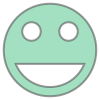

In [4]:
face = draw.shapely.geometry.Point(0, 0).buffer(1)
eye = draw.shapely.geometry.Point(0, 0).buffer(0.2)
eye_l = draw.translate(eye, -0.4, 0.4)
eye_r = draw.translate(eye, 0.4, 0.4)

smile = draw.shapely.geometry.Point(0, 0).buffer(0.8)
cut_sq = draw.shapely.geometry.box(-1, -0.3, 1, 1)
smile = draw.subtract(smile, cut_sq)
face = draw.subtract(face, smile)
face = draw.subtract(face, eye_r)
face = draw.subtract(face, eye_l)
face

This differs from qgeometries which have `subtract=True`, as that specifically sets that geometry to be "etched" from the ground plane. The polygon face is composed of an exterior;

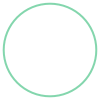

In [5]:
face.exterior

and interiors, such as;

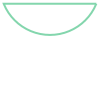

In [6]:
face.interiors[0]

A renderer must recognize the difference between these shapes, as the current QRenderers do. This allows for the component designer to generate complex shapes, without having to worry about how to add the qgeometries in any particular manner. This is also true with MultiPolygons.

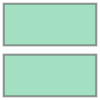

In [7]:
big_square = draw.rectangle(10,10,0,0)
cut_rectangle = draw.rectangle(12,1,0,0)
multi_poly = draw.subtract(big_square, cut_rectangle)
multi_poly

In [8]:
type(multi_poly)

shapely.geometry.multipolygon.MultiPolygon

The MultiPolygon can still just be passed to add_qgeometry as one would with a regular polygon. It is broken up behind the scenes so two separate rectangles (with the appropriate coordinates) are added to the poly qgeometry table. This is handled by the add_qgeometry method of QGeometryTables.

In [9]:
?metal.qgeometries.QGeometryTables.add_qgeometry

This method also handles rounding of coordinates to try and avoid any numerical errors. It is called by `metal.qlibrary.core.QComponent.add_qgeometry` and should not be called directly.

## QComponent Inheritance

As is the case with python classes, one can extend a given component by creating a qcomponent which inherits said class, making it a parent/child relationship. While python does support multiple inheritances, Metal may run into some bugs, so it is best to keep inheritances as single paths of heritage.

A good example is `TransmonPocketCL`, which adds a "charge line" the a "standard" `TransmonPocket`. As can be seen in the below code, none of the charge islands or other connection pads are present, but will still be generated via the `super().make()` line in the `make()` method.

In [10]:
import numpy as np
from qiskit_metal import draw, Dict
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket


class TransmonPocketCL(TransmonPocket):  # pylint: disable=invalid-name
    """
    The base `TransmonPocketCL` class

    Inherits `TransmonPocket` class

    Description:
        Create a standard pocket transmon qubit for a ground plane,
        with two pads connected by a junction (see drawing below).

        Connector lines can be added using the `connection_pads`
        dictionary. Each connector line has a name and a list of default
        properties.

        This is a child of TransmonPocket, see TransmonPocket for the variables and
        description of that class.

    ::

        _________________
        |               |
        |_______________|       ^
        ________x________       |  N
        |               |       |
        |_______________|


    .. image::
        Component_Qubit_Transmon_Pocket_CL.png


    Charge Line:
        * make_CL (bool): If a chargeline should be included.
        * cl_gap (string): The cpw dielectric gap of the charge line.
        * cl_width (string): The cpw width of the charge line.
        * cl_length (string):  The length of the charge line 'arm' coupling the the qubit pocket.
          Measured from the base of the 90 degree bend.
        * cl_ground_gap (string):  How much ground is present between the charge line and the
          qubit pocket.
        * cl_pocket_edge (string): What side of the pocket the charge line is.
          -180 to +180 from the 'west edge', will round to the nearest 90.
        * cl_off_center (string):  Distance from the center axis the qubit pocket is referenced to
    """
    component_metadata = Dict(short_name='Q', _qgeometry_table_poly='True')
    """Component metadata"""

    default_options = Dict(
        make_CL=True,
        cl_gap='6um',  # the cpw dielectric gap of the charge line
        cl_width='10um',  # the cpw trace width of the charge line
        # the length of the charge line 'arm' coupling the the qubit pocket.
        cl_length='20um',
        # Measured from the base of the 90 degree bend
        cl_ground_gap=
        '6um',  # how much ground between the charge line and the qubit pocket
        # -180 to +180 from the 'left edge', will round to the nearest 90.
        cl_pocket_edge='0',
        cl_off_center=
        '100um',  # distance from the center axis the qubit pocket is built on
    )
    """Default drawing options"""

    def make(self):
        """Define the way the options are turned into QGeometry."""
        super().make()

        if self.options.make_CL == True:
            self.make_charge_line()


#####################################################################

    def make_charge_line(self):
        """Creates the charge line if the user has charge line option to TRUE
        """

        # Grab option values
        name = 'Charge_Line'

        p = self.p

        cl_arm = draw.box(0, 0, -p.cl_width, p.cl_length)
        cl_cpw = draw.box(0, 0, -8 * p.cl_width, p.cl_width)
        cl_metal = draw.cascaded_union([cl_arm, cl_cpw])

        cl_etcher = draw.buffer(cl_metal, p.cl_gap)

        port_line = draw.LineString([(-8 * p.cl_width, 0),
                                     (-8 * p.cl_width, p.cl_width)])

        polys = [cl_metal, cl_etcher, port_line]

        # Move the charge line to the side user requested
        cl_rotate = 0
        if (abs(p.cl_pocket_edge) > 135) or (abs(p.cl_pocket_edge) < 45):
            polys = draw.translate(
                polys, -(p.pocket_width / 2 + p.cl_ground_gap + p.cl_gap),
                -(p.pad_gap + p.pad_height) / 2)
            if (abs(p.cl_pocket_edge) > 135):
                p.cl_rotate = 180
        else:
            polys = draw.translate(
                polys, -(p.pocket_height / 2 + p.cl_groundGap + p.cl_gap),
                -(p.pad_width) / 2)
            cl_rotate = 90
            if (p.cl_pocket_edge < 0):
                cl_rotate = -90

        # Rotate it to the pockets orientation
        polys = draw.rotate(polys, p.orientation + cl_rotate, origin=(0, 0))

        # Move to the final position
        polys = draw.translate(polys, p.pos_x, p.pos_y)

        [cl_metal, cl_etcher, port_line] = polys

        # Generating pins
        points = list(draw.shapely.geometry.shape(port_line).coords)
        self.add_pin(name, points, p.cl_width)  # TODO: chip

        # Adding to element table
        self.add_qgeometry('poly', dict(cl_metal=cl_metal))
        self.add_qgeometry('poly', dict(cl_etcher=cl_etcher), subtract=True)

We can see this is the case by generating a TransmonPocketCL in the GUI.

In [11]:
gui = metal.MetalGUI(design)

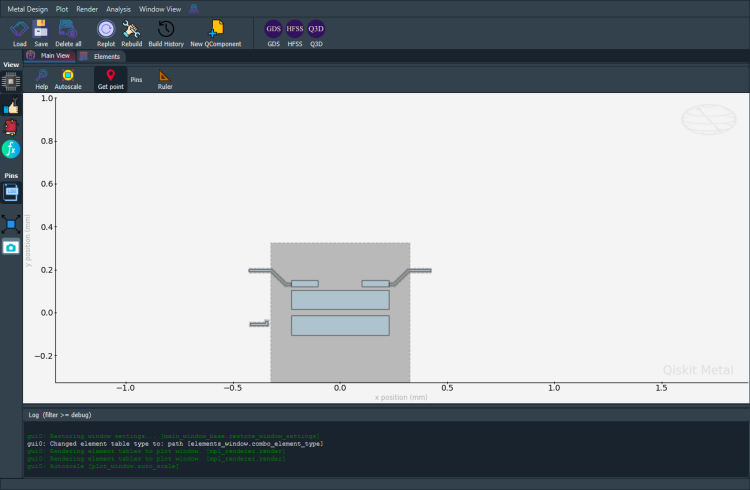

In [12]:
my_transmon_cl = TransmonPocketCL(design,'my_transmon_cl',options=dict(connection_pads=dict(a=dict(),b=dict(loc_W=-1))))
gui.rebuild()
gui.autoscale()
gui.screenshot()

In [13]:
my_transmon_cl.options

{'pos_x': '0um',
 'pos_y': '0um',
 'connection_pads': {'a': {'pad_gap': '15um',
   'pad_width': '125um',
   'pad_height': '30um',
   'pad_cpw_shift': '5um',
   'pad_cpw_extent': '25um',
   'cpw_width': 'cpw_width',
   'cpw_gap': 'cpw_gap',
   'cpw_extend': '100um',
   'pocket_extent': '5um',
   'pocket_rise': '65um',
   'loc_W': '+1',
   'loc_H': '+1'},
  'b': {'pad_gap': '15um',
   'pad_width': '125um',
   'pad_height': '30um',
   'pad_cpw_shift': '5um',
   'pad_cpw_extent': '25um',
   'cpw_width': 'cpw_width',
   'cpw_gap': 'cpw_gap',
   'cpw_extend': '100um',
   'pocket_extent': '5um',
   'pocket_rise': '65um',
   'loc_W': -1,
   'loc_H': '+1'}},
 'chip': 'main',
 'pad_gap': '30um',
 'inductor_width': '20um',
 'pad_width': '455um',
 'pad_height': '90um',
 'pocket_width': '650um',
 'pocket_height': '650um',
 'orientation': '0',
 'make_CL': True,
 'cl_gap': '6um',
 'cl_width': '10um',
 'cl_length': '20um',
 'cl_ground_gap': '6um',
 'cl_pocket_edge': '0',
 'cl_off_center': '100um',
 'h

We can see that `my_transmon_cl` inherited the appropriate options from `TransmonPocket`, and even got the junction renderer options since its parent class does declare `_qgeometry_table_junction='True'`

In [14]:
gui.main_window.close()

True